# Creating a multiclass dataset

In [2]:
# Import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [3]:
# Set the hyperparameters for the data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

In [4]:
# Creating the data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                            cluster_std = 1.5,   # Give the data little shakeup
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob[:5],X_blob.dtype, y_blob[:5],y_blob.dtype

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 torch.float32,
 tensor([3., 2., 2., 1., 1.]),
 torch.float32)

In [5]:
# Splitting data into training and testing data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
X_blob_train.shape, X_blob_test.shape, y_blob_train.shape, y_blob_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

In [6]:
X_blob_train[:10], y_blob_train[:10]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175],
         [ 0.7755,  7.8018],
         [-4.2962,  9.9991],
         [ 3.8225,  2.5719],
         [-7.6469,  5.4421],
         [-3.7474,  8.5322]]),
 tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.]))

In [7]:
# Checking number of classes
torch.unique(y_blob_train)

tensor([0., 1., 2., 3.])

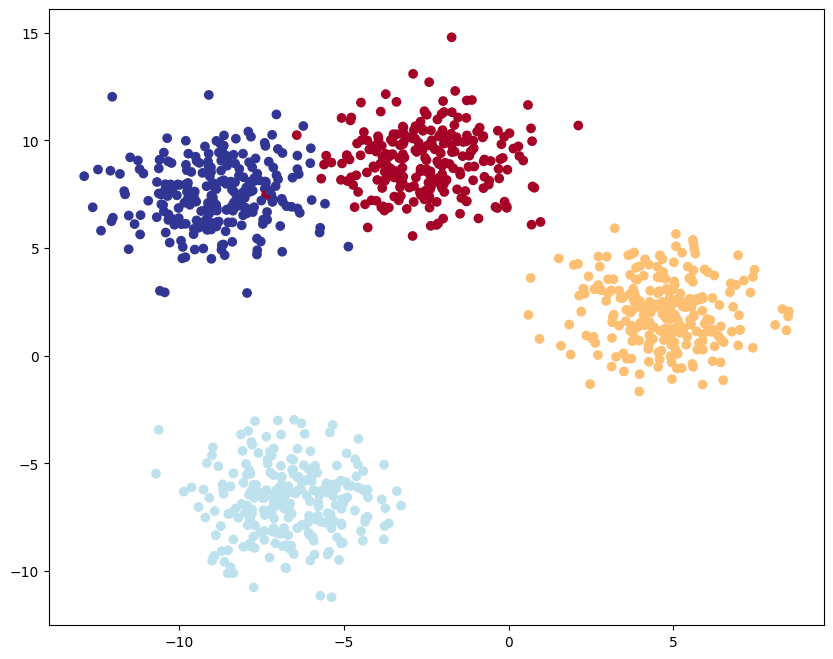

In [8]:
# Plotting the generated data
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

# Building multiclass calssification model

In [9]:
# Creating device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
# Building model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes multi-class classification model

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (Number of output classes)
      hidden_units (int): Number of hidden units between layers, default-8

    Returns:

    Examples:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [11]:
model_blob_0 = BlobModel(input_features=2,
                         output_features=4,
                         hidden_units=8).to(device)
model_blob_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## Creating loss function and optimizer for our model

* While using `CrossEntropyLoss` as a loss function we can use `weight` parameter (should be a 1D Tensor) assigning weight to each of the clases when we have `unbalanced classes` in our training dataset.

In [12]:
# Loss function for multiclass classification
loss_fn = nn.CrossEntropyLoss()

# Setting our Optimizer
optimizer = torch.optim.SGD(params=model_blob_0.parameters(),
                            lr=0.1)

In [13]:
# Calculate accuracy
# Accuracy = True Positive / (True Positive + True Negative) * 100
def accuracy_fn(y_true, y_pred):
  # torch.eq checks how many y_true == y_pred
  # item() is used to extract scaler valur from tensor(deals with tensors with only one value)
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [14]:
# getting predection propabilities for our model before training (checking raw logits)
model_blob_0.eval()
with torch.inference_mode():
  y_logits = model_blob_0(X_blob_train.to(device))

print("Logits:\n",y_logits[:10])

# logits -> predicted probabilities -> prediction labels
y_pred_probs = torch.softmax(y_logits, dim=1)

print("Softmax ouput:\n",y_pred_probs[:10])

Logits:
 tensor([[-0.2477,  0.2239, -0.1831, -1.2123],
        [-0.7746,  0.1938, -3.1632, -1.2304],
        [ 1.5710, -0.9710,  2.0851,  2.7034],
        [ 0.9617, -0.6371,  0.9153,  1.5886],
        [-0.4835,  0.0498, -2.5082, -0.7438],
        [-0.6627,  0.2578, -2.1752, -1.3972],
        [-0.7855,  0.1441, -3.5278, -1.0852],
        [-0.1283,  0.1349, -0.0999, -0.9237],
        [-0.1587, -0.2247, -2.4809,  0.1368],
        [-0.6274,  0.0963, -2.9845, -0.9111]])
Softmax ouput:
 tensor([[0.2469, 0.3957, 0.2634, 0.0941],
        [0.2294, 0.6042, 0.0210, 0.1454],
        [0.1708, 0.0134, 0.2856, 0.5301],
        [0.2482, 0.0502, 0.2370, 0.4646],
        [0.2772, 0.4725, 0.0366, 0.2137],
        [0.2375, 0.5962, 0.0523, 0.1139],
        [0.2305, 0.5839, 0.0148, 0.1708],
        [0.2645, 0.3441, 0.2721, 0.1194],
        [0.2960, 0.2771, 0.0290, 0.3978],
        [0.2558, 0.5274, 0.0242, 0.1926]])


In [15]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 1, 3, 3, 1, 1, 1, 1, 3, 1])

In [16]:
y_blob_train[:10]

tensor([1., 0., 2., 2., 0., 0., 0., 1., 3., 0.])

### So the process is :
Logits(raw model output) -> pred probs (use `torch.softmax()`) -> pred labels(take `torch.argmax()` of pred probs output)

# Building our training and testing loop

In [17]:
y_blob_train.dtype

torch.float32

In [18]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

### Training loop
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):

  ### Training
  model_blob_0.train()

  # Forward Pass
  y_logits = model_blob_0(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train.long())
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # Optimize zero grad
  optimizer.zero_grad()

  # back propagation
  loss.backward()

  # optimize the setp
  optimizer.step()

  ### Testing
  model_blob_0.eval()
  with torch.inference_mode():
    test_logits = model_blob_0(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test.long())
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

  # Printing vurbose
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.4f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.4f}%")

Epoch: 0 | Loss: 1.22100, Acc: 30.5000% | Test Loss: 0.56215, Test Acc: 74.5000%
Epoch: 10 | Loss: 0.14992, Acc: 99.1250% | Test Loss: 0.13644, Test Acc: 99.0000%
Epoch: 20 | Loss: 0.08505, Acc: 99.1250% | Test Loss: 0.07704, Test Acc: 99.5000%
Epoch: 30 | Loss: 0.06246, Acc: 99.1250% | Test Loss: 0.05496, Test Acc: 99.5000%
Epoch: 40 | Loss: 0.05143, Acc: 99.1250% | Test Loss: 0.04384, Test Acc: 99.5000%
Epoch: 50 | Loss: 0.04503, Acc: 99.1250% | Test Loss: 0.03724, Test Acc: 99.5000%
Epoch: 60 | Loss: 0.04090, Acc: 99.1250% | Test Loss: 0.03289, Test Acc: 99.5000%
Epoch: 70 | Loss: 0.03803, Acc: 99.1250% | Test Loss: 0.02982, Test Acc: 99.5000%
Epoch: 80 | Loss: 0.03594, Acc: 99.1250% | Test Loss: 0.02754, Test Acc: 99.5000%
Epoch: 90 | Loss: 0.03435, Acc: 99.1250% | Test Loss: 0.02578, Test Acc: 99.5000%


# Making and evaluating predictions

In [19]:
# Prediction
model_blob_0.eval()
with torch.inference_mode():
  y_logits = model_blob_0(X_blob_test)

y_logits[:10]

tensor([[  3.7071,   9.3550, -13.2919,  -9.6105],
        [  2.7890, -13.1833,   1.1070,   8.3847],
        [ -5.8057, -12.1509,  21.5211,  13.1722],
        [  1.5202,   7.1126,  -6.7462,  -6.4585],
        [  6.2438,   1.4680, -15.2266,  -5.1703],
        [  3.0565, -16.2239,   2.0948,  10.5582],
        [ -5.9092,  -8.9126,  20.0266,  10.7396],
        [  5.1792,  -2.3622, -10.5626,  -1.5217],
        [ -6.1512, -17.4039,  25.1979,  17.4518],
        [  5.4673,  -0.9352, -12.0356,  -2.8106]])

In [20]:
# from logits to predictions
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[3.5124e-03, 9.9649e-01, 1.4555e-10, 5.7791e-09],
        [3.6976e-03, 4.2777e-10, 6.8772e-04, 9.9561e-01],
        [1.3554e-12, 2.3789e-15, 9.9976e-01, 2.3661e-04],
        [3.7122e-03, 9.9629e-01, 9.5412e-07, 1.2722e-06],
        [9.9163e-01, 8.3615e-03, 4.6978e-10, 1.0947e-05],
        [5.5172e-04, 2.3353e-12, 2.1089e-04, 9.9924e-01],
        [5.4471e-12, 2.7029e-13, 9.9991e-01, 9.2609e-05],
        [9.9824e-01, 5.2973e-04, 1.4544e-07, 1.2277e-03],
        [2.4270e-14, 3.1483e-19, 9.9957e-01, 4.3223e-04],
        [9.9809e-01, 1.6541e-03, 2.4989e-08, 2.5359e-04]])

In [21]:
# pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [22]:
y_blob_test[:10]

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0.])

# Visualize the test result

In [23]:
import requests
from pathlib import Path

# Download helper functions from learn pytorch repo(if it is not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already existis")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [24]:
from helper_functions import plot_predictions, plot_decision_boundary

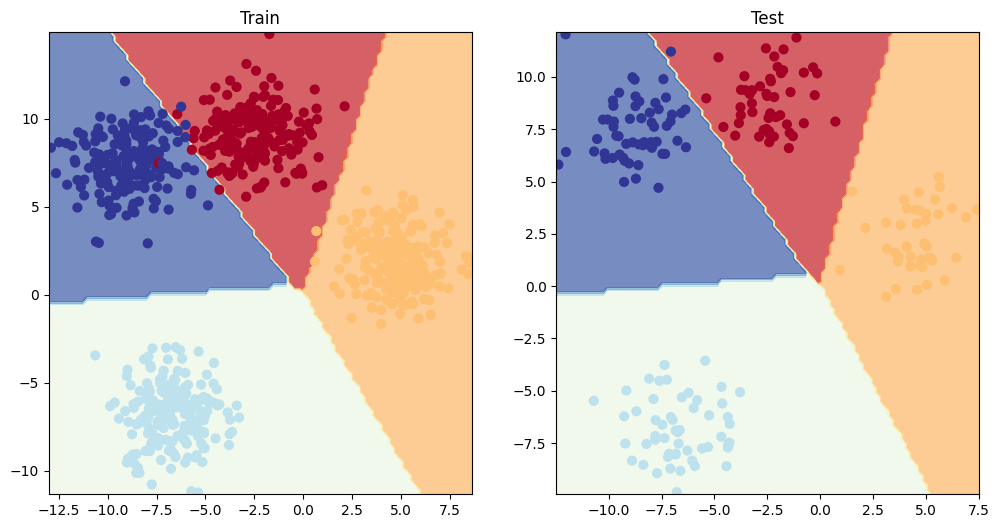

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_blob_0, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_blob_0, X_blob_test, y_blob_test)

# Evaluating the model with more classification metices

* `Accuracy:` (This is mostly used when we have balanced classes)
-> For imbalanced classes we should use the following matrices:
* `Precision:` Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives
              TP/(TP+FP)
* `Recall:` The precise definition of recall is the number of true positives divided by the number of true positives plus the number of false negatives.
              TP/(TP+FN)
-> To create a balanced classification model with optimam balance of precision and recall, then we should use F1 Score
* `F1 Score:` The F1 score is the harmonic mean of precision and recall taking both metrics into account
      2 * ((precision * recall) / (precision + recall))


* `True Negative:` True negative are data points classified by the model as negative which are actually negative.
* `True Positive:` True positives are data point classified as positive by the model that actually are positive (meaning they are correct)
* `False Negative:` False negatives are data points the model identifies as negative that actually are positive (incorrect)
* `False Positive:` False positives are cases the model incorrectly labels as positive that are actually negative



In [26]:
!pip install torchmetrics

In [30]:
from torchmetrics import Accuracy, F1Score

"""
The 'task' parameter can take values like 'binary', 'multiclass', or 'multilabel',
depending on the nature of classification problem.
"""
task = 'multiclass'

# Setup metric
torchmetrics_accuracy = Accuracy(task=task, num_classes=4).to(device)
torchmetrics_f1_score = F1Score(task=task, num_classes=4).to(device)

# Calculate accuracy
acc = torchmetrics_accuracy(y_preds, y_blob_test)
f1 = torchmetrics_f1_score(y_preds, y_blob_test)

print(f"Model test Accuracy: {acc*100}% | F1 Score: {f1}")

Model test Accuracy: 99.5% | F1 Score: 0.9950000047683716
